# Michelin Restaurants in France - *Arrondissements*

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

Importing restaurant data

In [2]:
france_data = pd.read_csv("../../data/France/all_restaurants.csv")
france_data.head()

,name,address,location,department_num,department,capital,region,price,cuisine,url,award,stars,longitude,latitude
0,La Table du Castellet,"3001 route des Hauts-du-Camp, au Circuit Paul ...","Le Castellet, 83330",83,Var,Toulon,Provence-Alpes-Côte d'Azur,€€€€,Creative,http://www.hotelducastellet.net/fr/restaurants...,3 Stars,3.0,5.783887,43.249929
1,Plénitude - Cheval Blanc Paris,8 quai du Louvre,"Paris, 75001",75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.chevalblanc.com/fr/maison/paris/,3 Stars,3.0,2.342159,48.858815
2,Le Petit Nice,Anse de Maldormé,"Marseille, 13007",13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,Seafood,https://www.passedat.fr,3 Stars,3.0,5.352121,43.280086
3,Mirazur,30 avenue Aristide-Briand,"Menton, 06500",06,Alpes-Maritimes,Nice,Provence-Alpes-Côte d'Azur,€€€€,Creative,https://www.mirazur.fr/,3 Stars,3.0,7.528051,43.785930
4,AM par Alexandre Mazzia,9 rue François-Rocca,"Marseille, 13008",13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,Creative,https://www.alexandre-mazzia.com/,3 Stars,3.0,5.386233,43.270110


In [3]:
print(france_data.columns.tolist())

['name', 'address', 'location', 'department_num', 'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude']


----
&nbsp;
Demographics data from [INSEE](https://statistiques-locales.insee.fr/#c=indicator&view=map5)

In [4]:
stats_locale = pd.read_csv("../../../../ExtraData/Demographics/arrondissements_data.csv", sep=';')
print(stats_locale.columns.tolist())

['Code', 'Libellé', 'Population municipale 2020', 'Taux de pauvreté 2020', 'Densité de population (historique depuis 1876) 2020', 'Salaire net horaire moyen 2021']


In [5]:
stats_locale = stats_locale.rename(columns={
    'Code': 'code',
    'Libellé': 'arrondissement',
    'Taux de pauvreté 2020': 'poverty_rate(%)',
    'Salaire net horaire moyen 2021': 'average_net_hourly_wage(€)',
    'Population municipale 2020': 'municipal_population',
    'Densité de population (historique depuis 1876) 2020': 'population_density(inhabitants/sq_km)',
})
stats_locale = stats_locale[['code', 'arrondissement', 'municipal_population', 'population_density(inhabitants/sq_km)',
                             'poverty_rate(%)', 'average_net_hourly_wage(€)']]
stats_locale.head()

,code,arrondissement,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€)
0,011,Belley,123405,77.9,10.2,15.3
1,012,Bourg-en-Bresse,340382,118.4,8.8,15.65
2,013,Gex,100314,247.8,12.4,15.32
3,014,Nantua,93755,104.2,15.5,14.14
4,021,Château-Thierry,70094,62.9,14,14.36


In [6]:
print(stats_locale.columns.tolist())

['code', 'arrondissement', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)']


Loading in [GeoJSON data](https://github.com/gregoiredavid/france-geojson/blob/master/arrondissements-avec-outre-mer.geojson)

In [7]:
# Load the GeoJSON file
geoJSON_df = gpd.read_file('../../../../ExtraData/Geodata/arrondissements-avec-outre-mer.geojson')
geoJSON_df.head()

,code,nom,geometry
0,01001,Belley,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01002,Bourg-en-Bresse,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ..."
2,01003,Gex,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ..."
3,01004,Nantua,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02001,Château-Thierry,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


In [8]:
print(geoJSON_df.columns.tolist())

['code', 'nom', 'geometry']


----
&nbsp;
### Removing *outre-mers*

In [9]:
# We leverage the format of the first two digits of the 'code' column
# where 01 - 95 represents mainland france
geoJSON_df = geoJSON_df.sort_values(by='code')
geoJSON_df = geoJSON_df[~geoJSON_df['code'].str.startswith('97')]
geoJSON_df = geoJSON_df.reset_index(drop=True)
geoJSON_df.shape

(320, 3)

In [10]:
# We again remove '97' leveraging a pattern
stats_locale = stats_locale.sort_values(by='code')
stats_locale = stats_locale[~stats_locale['code'].str.startswith('97')]
stats_locale = stats_locale.reset_index(drop=True)
stats_locale.shape

(320, 6)

It's good news the dataframes have the same length

----
&nbsp;
### Looking for discrepancies in the `nom`, `arrondissement` columns

In [11]:
set1 = set(stats_locale['arrondissement'].unique())
set2 = set(geoJSON_df['nom'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? False


In [12]:
print("In set1 but not in set2: ", set1 - set2)
print("\nIn set2 but not in set1: ", set2 - set1)

In set1 but not in set2:  {"Les Sables-d'Olonne", 'Le Puy-en-Velay', 'La Rochelle', 'La Châtre', 'La Tour-du-Pin', "L'Haÿ-les-Roses", 'Le Blanc', 'La Flèche', 'Les Andelys', 'Le Raincy', 'La Roche-sur-Yon', 'Le Havre', 'Le Mans', 'Le Vigan', 'Val-de-Briey'}

In set2 but not in set1:  {'Briey', 'Roche-sur-Yon', 'Flèche', "Sables-d'Olonne", 'Raincy', 'Andelys', 'Blanc', 'Puy-en-Velay', 'Châtre', 'Haÿ-les-Roses', 'Mans', 'Havre', 'Tour-du-Pin', 'Vigan', 'Rochelle'}


We will remove articles from the `stats_locale` DataFrame. This will not significantly affect the ability to differentiate between *arrondissements*

In [13]:
def clean_name(name):
    # Remove common prefixes/articles
    for prefix in ['Le ', 'La ', 'Les ', "L'"]:
        if name.startswith(prefix):
            name = name[len(prefix):]
    return name.strip()

In [14]:
set1_clean = set(map(clean_name, stats_locale['arrondissement'].unique()))
set2_clean = set(map(clean_name, geoJSON_df['nom'].unique()))

# Update 'stats_locale' with the new names
stats_locale['arrondissement'] = stats_locale['arrondissement'].apply(clean_name)

In [15]:
# Check for discrepancies again
print("In set1_clean but not in set2_clean: ", set1_clean - set2_clean)
print("\nIn set2_clean but not in set1_clean: ", set2_clean - set1_clean)

In set1_clean but not in set2_clean:  {'Val-de-Briey'}

In set2_clean but not in set1_clean:  {'Briey'}


In [16]:
# Correct the discrepancy manually
if 'Val-de-Briey' in set1_clean and 'Briey' in set2_clean:
    geoJSON_df['nom'] = geoJSON_df['nom'].replace('Briey', 'Val-de-Briey')

# Validating and recomparing the sets
set1_clean = set(map(clean_name, stats_locale['arrondissement'].unique()))
set2_clean = set(map(clean_name, geoJSON_df['nom'].unique()))

print("In set1_clean but not in set2_clean: ", set1_clean - set2_clean)
print("\nIn set2_clean but not in set1_clean: ", set2_clean - set1_clean)

In set1_clean but not in set2_clean:  set()

In set2_clean but not in set1_clean:  set()


----
&nbsp;
### Mapping individual restaurants to *arrondissements* based on (latitude, longitude) Geospatial data

In [17]:
# Convert france_data to GeoDataFrame
geometry = [Point(xy) for xy in zip(france_data.longitude, france_data.latitude)]
france_geo = gpd.GeoDataFrame(france_data, geometry=geometry)

In [18]:
france_geo.head()

,name,address,location,department_num,department,capital,region,price,cuisine,url,award,stars,longitude,latitude,geometry
0,La Table du Castellet,"3001 route des Hauts-du-Camp, au Circuit Paul ...","Le Castellet, 83330",83,Var,Toulon,Provence-Alpes-Côte d'Azur,€€€€,Creative,http://www.hotelducastellet.net/fr/restaurants...,3 Stars,3.0,5.783887,43.249929,POINT (5.78389 43.24993)
1,Plénitude - Cheval Blanc Paris,8 quai du Louvre,"Paris, 75001",75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.chevalblanc.com/fr/maison/paris/,3 Stars,3.0,2.342159,48.858815,POINT (2.34216 48.85881)
2,Le Petit Nice,Anse de Maldormé,"Marseille, 13007",13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,Seafood,https://www.passedat.fr,3 Stars,3.0,5.352121,43.280086,POINT (5.35212 43.28009)
3,Mirazur,30 avenue Aristide-Briand,"Menton, 06500",06,Alpes-Maritimes,Nice,Provence-Alpes-Côte d'Azur,€€€€,Creative,https://www.mirazur.fr/,3 Stars,3.0,7.528051,43.785930,POINT (7.52805 43.78593)
4,AM par Alexandre Mazzia,9 rue François-Rocca,"Marseille, 13008",13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,Creative,https://www.alexandre-mazzia.com/,3 Stars,3.0,5.386233,43.270110,POINT (5.38623 43.27011)


In [19]:
france_geo.crs = "EPSG:4326"

In [20]:
joined_data = gpd.sjoin(france_geo, geoJSON_df[['nom', 'geometry']], predicate='within', how='left')
joined_data.rename(columns={'nom': 'arrondissement'}, inplace=True)

In [21]:
# Convert the GeoDataFrame to a normal DataFrame
france_df = pd.DataFrame(joined_data)

# Drop the 'geometry' and 'index_right' columns
france_df = france_df.drop(columns=['geometry', 'index_right'])
print(france_df.columns.tolist())

['name', 'address', 'location', 'department_num', 'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude', 'arrondissement']


In [22]:
new_order = ['name', 'address', 'location', 'arrondissement', 'department_num',
             'department', 'capital', 'region', 'price', 'cuisine', 'url',
             'award', 'stars', 'longitude', 'latitude']
france_df = france_df[new_order]
france_df.head(10)

,name,address,location,arrondissement,department_num,department,capital,region,price,cuisine,url,award,stars,longitude,latitude
0,La Table du Castellet,"3001 route des Hauts-du-Camp, au Circuit Paul ...","Le Castellet, 83330",Toulon,83,Var,Toulon,Provence-Alpes-Côte d'Azur,€€€€,Creative,http://www.hotelducastellet.net/fr/restaurants...,3 Stars,3.0,5.783887,43.249929
1,Plénitude - Cheval Blanc Paris,8 quai du Louvre,"Paris, 75001",Paris,75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.chevalblanc.com/fr/maison/paris/,3 Stars,3.0,2.342159,48.858815
2,Le Petit Nice,Anse de Maldormé,"Marseille, 13007",Marseille,13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,Seafood,https://www.passedat.fr,3 Stars,3.0,5.352121,43.280086
3,Mirazur,30 avenue Aristide-Briand,"Menton, 06500",Nice,06,Alpes-Maritimes,Nice,Provence-Alpes-Côte d'Azur,€€€€,Creative,https://www.mirazur.fr/,3 Stars,3.0,7.528051,43.785930
4,AM par Alexandre Mazzia,9 rue François-Rocca,"Marseille, 13008",Marseille,13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,Creative,https://www.alexandre-mazzia.com/,3 Stars,3.0,5.386233,43.270110
5,Pic,285 avenue Victor-Hugo,"Valence, 26000",Valence,26,Drôme,Valence,Auvergne-Rhône-Alpes,€€€€,Creative,http://www.anne-sophie-pic.com,3 Stars,3.0,4.885497,44.917785
6,Pierre Gagnaire,6 rue Balzac,"Paris, 75008",Paris,75,Paris,Paris,Île-de-France,€€€€,Creative,http://pierregagnaire-lerestaurant.com,3 Stars,3.0,2.300386,48.873251
7,Flocons de Sel,"1775 route du Leutaz, Le Leutaz","Megève, 74120",Bonneville,74,Haute-Savoie,Annecy,Auvergne-Rhône-Alpes,€€€€,Modern Cuisine,https://www.floconsdesel.com,3 Stars,3.0,6.596963,45.830240
8,Alléno Paris au Pavillon Ledoyen,8 avenue Dutuit,"Paris, 75008",Paris,75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.yannick-alleno.com,3 Stars,3.0,2.316499,48.866093
9,L'Ambroisie,9 place des Vosges,"Paris, 75004",Paris,75,Paris,Paris,Île-de-France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,2.364521,48.855494


In [23]:
france_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017 entries, 0 to 1016
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1017 non-null   object 
 1   address         1017 non-null   object 
 2   location        1017 non-null   object 
 3   arrondissement  1017 non-null   object 
 4   department_num  1017 non-null   object 
 5   department      1017 non-null   object 
 6   capital         1017 non-null   object 
 7   region          1017 non-null   object 
 8   price           1017 non-null   object 
 9   cuisine         1017 non-null   object 
 10  url             973 non-null    object 
 11  award           1017 non-null   object 
 12  stars           1017 non-null   float64
 13  longitude       1017 non-null   float64
 14  latitude        1017 non-null   float64
dtypes: float64(3), object(12)
memory usage: 127.1+ KB


In [24]:
# Unique arrondissement in the dataset
france_df.arrondissement.nunique()

223

----
&nbsp;
### Adding Parisien *arrondissement municipaux*

In [25]:
all_france = france_df.copy()

In [26]:
import certifi
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

url = 'https://en.wikipedia.org/wiki/Arrondissements_of_Paris'
tables = pd.read_html(url)

In [27]:
# The table of interest is found by inspection
paris_arr = tables[1]
paris_arr.head()

,Coat of arms,"Arrondissement (R for Right Bank, L for Left Bank)",Name,Area (km2),Population(2017 estimate),Density (2017)(inhabitants per km2),Peak of population,Mayor (2020–2026)
0,NaN,1st (Ier) RAdministratively part of Paris Centre,Louvre,5.59 km2 (2.16 sq mi),100196,17924,before 1861,Ariel Weil (PS)
1,NaN,2nd (IIe) RAdministratively part of Paris Centre,Bourse,5.59 km2 (2.16 sq mi),100196,17924,before 1861,Ariel Weil (PS)
2,NaN,3rd (IIIe) RAdministratively part of Paris Centre,Temple,5.59 km2 (2.16 sq mi),100196,17924,before 1861,Ariel Weil (PS)
3,NaN,4th (IVe) RAdministratively part of Paris Centre,Hôtel-de-Ville,5.59 km2 (2.16 sq mi),100196,17924,before 1861,Ariel Weil (PS)
4,NaN,5th (Ve) L,Panthéon,2.541 km2 (0.981 sq mi),59631,23477,1911,Florence Berthout (DVD)


In [28]:
print(paris_arr.columns.tolist())

['Coat of arms', 'Arrondissement (R for Right Bank, L for Left Bank)', 'Name', 'Area (km2)', 'Population(2017 estimate)', 'Density (2017)(inhabitants per km2)', 'Peak of population', 'Mayor (2020–2026)']


In [29]:
# Drop specified columns from the DataFrame
paris_arr = paris_arr.drop(columns=['Coat of arms', 'Area (km2)', 'Population(2017 estimate)', 'Density (2017)(inhabitants per km2)', 'Peak of population', 'Mayor (2020–2026)'])

paris_arr = paris_arr.rename(columns={'Arrondissement (R for Right Bank, L for Left Bank)': 'arrondissement', 'Name': 'name'})

In [30]:
# Extract the first part of the 'arrondissement' using regex
paris_arr['arrondissement'] = paris_arr['arrondissement'].str.extract(r'(\d+\w{2})')
paris_arr.head()

,arrondissement,name
0,1st,Louvre
1,2nd,Bourse
2,3rd,Temple
3,4th,Hôtel-de-Ville
4,5th,Panthéon


Search `france_data` for 'Paris'

In [31]:
paris_rows = all_france[all_france['location'].str.contains('Paris', case=False, na=False)]
paris_rows.head()

,name,address,location,arrondissement,department_num,department,capital,region,price,cuisine,url,award,stars,longitude,latitude
1,Plénitude - Cheval Blanc Paris,8 quai du Louvre,"Paris, 75001",Paris,75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.chevalblanc.com/fr/maison/paris/,3 Stars,3.0,2.342159,48.858815
6,Pierre Gagnaire,6 rue Balzac,"Paris, 75008",Paris,75,Paris,Paris,Île-de-France,€€€€,Creative,http://pierregagnaire-lerestaurant.com,3 Stars,3.0,2.300386,48.873251
8,Alléno Paris au Pavillon Ledoyen,8 avenue Dutuit,"Paris, 75008",Paris,75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.yannick-alleno.com,3 Stars,3.0,2.316499,48.866093
9,L'Ambroisie,9 place des Vosges,"Paris, 75004",Paris,75,Paris,Paris,Île-de-France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,2.364521,48.855494
10,Le Pré Catelan,Route de Suresnes - bois de Boulogne,"Paris, 75016",Paris,75,Paris,Paris,Île-de-France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,3.0,2.250718,48.863937


In [32]:
# Mask to identify rows with 'arrondissement' == 'Paris'
mask_paris = all_france['arrondissement'] == 'Paris'

# Extract the last two digits from the postal code for the mask
all_france.loc[mask_paris, 'postal_digits'] = all_france.loc[mask_paris, 'location'].str[-2:].astype(int)

# Overwrite the 'arrondissement' column for the mask
all_france.loc[mask_paris, 'arrondissement'] = all_france.loc[mask_paris, 'postal_digits']

# Drop the temporary 'postal_digits' column
all_france.drop(columns=['postal_digits'], inplace=True, errors='ignore')  # Using errors='ignore' to ensure code doesn't break if column doesn't exist

In [33]:
all_france.head()

,name,address,location,arrondissement,department_num,department,capital,region,price,cuisine,url,award,stars,longitude,latitude
0,La Table du Castellet,"3001 route des Hauts-du-Camp, au Circuit Paul ...","Le Castellet, 83330",Toulon,83,Var,Toulon,Provence-Alpes-Côte d'Azur,€€€€,Creative,http://www.hotelducastellet.net/fr/restaurants...,3 Stars,3.0,5.783887,43.249929
1,Plénitude - Cheval Blanc Paris,8 quai du Louvre,"Paris, 75001",1.0,75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.chevalblanc.com/fr/maison/paris/,3 Stars,3.0,2.342159,48.858815
2,Le Petit Nice,Anse de Maldormé,"Marseille, 13007",Marseille,13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,Seafood,https://www.passedat.fr,3 Stars,3.0,5.352121,43.280086
3,Mirazur,30 avenue Aristide-Briand,"Menton, 06500",Nice,06,Alpes-Maritimes,Nice,Provence-Alpes-Côte d'Azur,€€€€,Creative,https://www.mirazur.fr/,3 Stars,3.0,7.528051,43.785930
4,AM par Alexandre Mazzia,9 rue François-Rocca,"Marseille, 13008",Marseille,13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,Creative,https://www.alexandre-mazzia.com/,3 Stars,3.0,5.386233,43.270110


In [34]:
# Filter out Paris rows
paris_rows = all_france[all_france['department'].str.contains('Paris', case=False, na=False)].copy()

In [35]:
# Extract numbers from "1st", "2nd", etc. in paris_arr to a new temporary column
paris_arr['arr_num'] = paris_arr['arrondissement'].str.extract('(\d+)').astype(float)

# Create a dictionary that maps these numbers to the tuple (arrondissement, name)
paris_tuple_dict = dict(zip(paris_arr['arr_num'], zip(paris_arr['arrondissement'], paris_arr['name'])))
paris_tuple_dict = {k: f"{v[0]} ({v[1]})" for k, v in paris_tuple_dict.items()}

In [36]:
# Map the arrondissement values in all_france to the paris_tuple_dict
new_arr_values = all_france['arrondissement'].map(paris_tuple_dict)

# Fill NaN values with existing values from arrondissement column
new_arr_values.fillna(all_france['arrondissement'], inplace=True)

In [37]:
# Assign the new series to the arrondissement column
all_france['arrondissement'] = new_arr_values
all_france.head()

,name,address,location,arrondissement,department_num,department,capital,region,price,cuisine,url,award,stars,longitude,latitude
0,La Table du Castellet,"3001 route des Hauts-du-Camp, au Circuit Paul ...","Le Castellet, 83330",Toulon,83,Var,Toulon,Provence-Alpes-Côte d'Azur,€€€€,Creative,http://www.hotelducastellet.net/fr/restaurants...,3 Stars,3.0,5.783887,43.249929
1,Plénitude - Cheval Blanc Paris,8 quai du Louvre,"Paris, 75001",1st (Louvre),75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.chevalblanc.com/fr/maison/paris/,3 Stars,3.0,2.342159,48.858815
2,Le Petit Nice,Anse de Maldormé,"Marseille, 13007",Marseille,13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,Seafood,https://www.passedat.fr,3 Stars,3.0,5.352121,43.280086
3,Mirazur,30 avenue Aristide-Briand,"Menton, 06500",Nice,06,Alpes-Maritimes,Nice,Provence-Alpes-Côte d'Azur,€€€€,Creative,https://www.mirazur.fr/,3 Stars,3.0,7.528051,43.785930
4,AM par Alexandre Mazzia,9 rue François-Rocca,"Marseille, 13008",Marseille,13,Bouches-du-Rhône,Marseille,Provence-Alpes-Côte d'Azur,€€€€,Creative,https://www.alexandre-mazzia.com/,3 Stars,3.0,5.386233,43.270110


In [38]:
paris = all_france[all_france['department'].str.contains('Paris', case=False, na=False)].copy()
print(f"Shape: {paris.shape}")
paris.head()

Shape: (153, 15)


,name,address,location,arrondissement,department_num,department,capital,region,price,cuisine,url,award,stars,longitude,latitude
1,Plénitude - Cheval Blanc Paris,8 quai du Louvre,"Paris, 75001",1st (Louvre),75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.chevalblanc.com/fr/maison/paris/,3 Stars,3.0,2.342159,48.858815
6,Pierre Gagnaire,6 rue Balzac,"Paris, 75008",8th (Élysée),75,Paris,Paris,Île-de-France,€€€€,Creative,http://pierregagnaire-lerestaurant.com,3 Stars,3.0,2.300386,48.873251
8,Alléno Paris au Pavillon Ledoyen,8 avenue Dutuit,"Paris, 75008",8th (Élysée),75,Paris,Paris,Île-de-France,€€€€,Creative,https://www.yannick-alleno.com,3 Stars,3.0,2.316499,48.866093
9,L'Ambroisie,9 place des Vosges,"Paris, 75004",4th (Hôtel-de-Ville),75,Paris,Paris,Île-de-France,€€€€,Classic Cuisine,https://www.ambroisie-paris.com/,3 Stars,3.0,2.364521,48.855494
10,Le Pré Catelan,Route de Suresnes - bois de Boulogne,"Paris, 75016",16th (Passy),75,Paris,Paris,Île-de-France,€€€€,"Creative, Contemporary",https://www.leprecatelan.com/,3 Stars,3.0,2.250718,48.863937


----
&nbsp;
### Exporting to .csv file

In [39]:
# Export the DataFrame to a .csv file
all_france.to_csv('../../data/France/all_restaurants(arrondissements).csv', index=False)

----
&nbsp;
## Grouping by *arrondissement* based on number of Michelin stars

In [40]:
france_data_copy = france_df.copy()

# Create dummy variables for each category of 'star'
france_data_copy['bib_gourmand'] = france_data_copy['stars'].apply(lambda x: 1 if x == 0.5 else 0)
france_data_copy['1_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 1.0 else 0)
france_data_copy['2_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 2.0 else 0)
france_data_copy['3_star'] = france_data_copy['stars'].apply(lambda x: 1 if x == 3.0 else 0)

#### By *`arrondissement`*
We sort `france_data` by total number of awarded restaurants

In [41]:
# Group by 'arrondissement' and sum 'bib', '1_star', '2_star' and '3_star'
arrondissement_grouped = france_data_copy.groupby('arrondissement')[['bib_gourmand', '1_star', '2_star', '3_star']].sum()

# Create a copy for plotting
arrondissement_grouped_two = arrondissement_grouped.copy()

`arrondissement_grouped` is created to be merged with the demographics data

In [42]:
# Create a 'total_ star' column - sum of stars
# Individual stars are summed here. ie, If 2 star then stars = 2
arrondissement_grouped['total_stars'] = arrondissement_grouped['1_star']*1 + arrondissement_grouped['2_star']*2 + arrondissement_grouped['3_star']*3

# Create a 'total' column = sum of restaurants
arrondissement_grouped['starred_restaurants'] =  arrondissement_grouped['1_star'] + arrondissement_grouped['2_star'] + arrondissement_grouped['3_star']

# Sort the dataframe by the 'total_stars' column in descending order
arrondissement_grouped.sort_values('total_stars', ascending=True, inplace=True)

In [43]:
arrondissement_grouped.head()

,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants
arrondissement,,,,,,
Abbeville,2,0,0,0,0,0
Charleville-Mézières,1,0,0,0,0,0
Chinon,2,0,0,0,0,0
Cholet,1,0,0,0,0,0
Châteaubriant-Ancenis,1,0,0,0,0,0


----
&nbsp;
## Plotting starred restaurants by *`arrondissement`*

We use `arrondissement_grouped_two` for plotting whilst excluding Paris

In [44]:
# Create a 'total_starred' column - sum of starred restaurants
arrondissement_grouped_two['total_starred'] = arrondissement_grouped_two['1_star'] + arrondissement_grouped_two['2_star'] + arrondissement_grouped_two['3_star']

# Sort the dataframes by the 'total' and 'total_stars' columns in descending order
arrondissement_grouped_two.sort_values('total_starred', ascending=True, inplace=True)

In [45]:
# Exclude 'Paris'
arrondissement_grouped_no_paris = arrondissement_grouped_two[arrondissement_grouped_two.index.get_level_values('arrondissement') != 'Paris']

In [46]:
# Sort by 'total_starred' in descending order and keep the top 10
arrondissement_grouped_top10 = arrondissement_grouped_no_paris.sort_values('total_starred', ascending=False).head(10)

# Drop the 'bib_gourmand' & 'total' columns
arrondissement_grouped_top10 = arrondissement_grouped_top10.drop(columns=['bib_gourmand', 'total_starred'])

# Reverse the order of the DataFrame
arrondissement_grouped_top10 = arrondissement_grouped_top10.iloc[::-1]

Plot the data

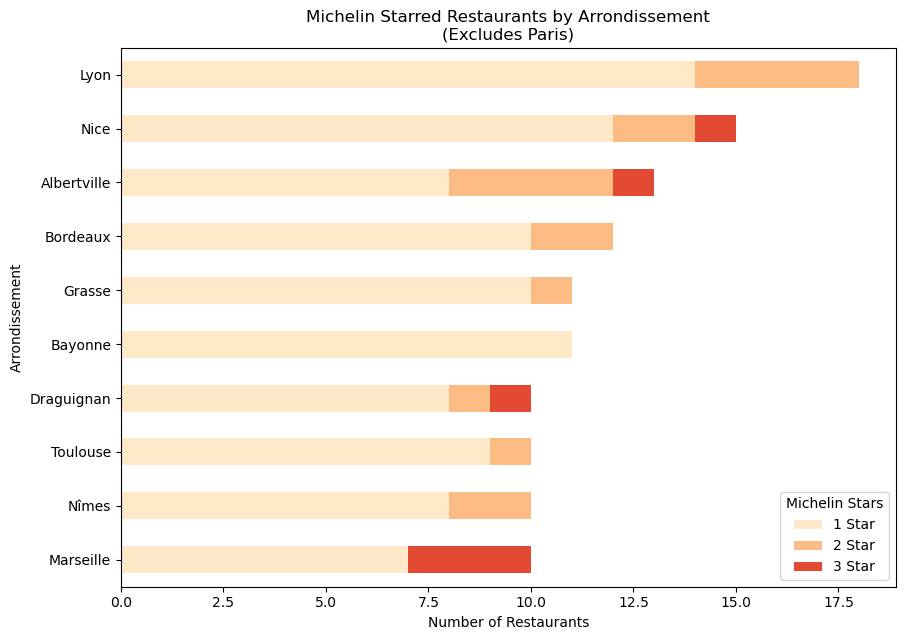

In [47]:
# Create a horizontal stacked bar plot
arrondissement_grouped_top10.plot(kind='barh', stacked=True, figsize=(10, 7),
                    color=['#fee8c8','#fdbb84','#e34a33'])

# Add title and labels
plt.title('Michelin Starred Restaurants by Arrondissement\n(Excludes Paris)')
plt.ylabel('Arrondissement')
plt.xlabel('Number of Restaurants')

# Add a legend
plt.legend(title='Michelin Stars', labels=['1 Star', '2 Star', '3 Star'])

# Show the plot
plt.show()

----
&nbsp;
#### We now cascade merges from the smallest granularity (arrondissement) up to the highest (region) using the department as an intermediary linking point.

#### 1. Extract departmental code from `geoJSON_df`

In [48]:
geoJSON_df['department_num'] = geoJSON_df['code'].str[:2]
print(f"Shape: {geoJSON_df.shape}")
print(f"Columns: {geoJSON_df.columns.tolist()}")
geoJSON_df.head(3)

Shape: (320, 4)
Columns: ['code', 'nom', 'geometry', 'department_num']


,code,nom,geometry,department_num
0,01001,Belley,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ...",01
1,01002,Bourg-en-Bresse,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ...",01
2,01003,Gex,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ...",01


#### 2. Extract department name from file produced in `France_Departments_Regions.ipynb`

In [50]:
departments = gpd.read_file("../../../../ExtraData/Geodata/departements.geojson")
print(f"Shape: {departments.shape}")
print(f"Columns: {departments.columns.tolist()}")
departments.head()

Shape: (96, 3)
Columns: ['code', 'nom', 'geometry']


,code,nom,geometry
0,01,Ain,"POLYGON ((4.78021 46.17668, 4.78024 46.18905, ..."
1,02,Aisne,"POLYGON ((3.17296 50.01131, 3.17382 50.01186, ..."
2,03,Allier,"POLYGON ((3.03207 46.79491, 3.03424 46.79080, ..."
3,04,Alpes-de-Haute-Provence,"POLYGON ((5.67604 44.19143, 5.67817 44.19051, ..."
4,05,Hautes-Alpes,"POLYGON ((6.26057 45.12685, 6.26417 45.12641, ..."


In [51]:
# Merge the dataframes on the appropriate columns
merged_geo_df = pd.merge(geoJSON_df[['code', 'nom', 'geometry', 'department_num']],
                         departments[['code', 'nom']],
                         left_on='department_num', right_on='code',
                         how='left', suffixes=('_arrondissement', '_department'))

In [52]:
print(f"Shape: {merged_geo_df.shape}")

Shape: (320, 6)


In [53]:
print(f"Columns: {merged_geo_df.columns.tolist()}")

Columns: ['code_arrondissement', 'nom_arrondissement', 'geometry', 'department_num', 'code_department', 'nom_department']


In [54]:
# Drop 'code_department'
merged_geo_df.drop('code_department', axis=1, inplace=True)

# Rename columns
column_rename_map = {
    'nom_arrondissement': 'arrondissement',
    'nom_department': 'department'
}
merged_geo_df.rename(columns=column_rename_map, inplace=True)

# Rearrange columns
new_order = ['code_arrondissement', 'arrondissement', 'department_num', 'department', 'geometry']
merged_geo_df = merged_geo_df[new_order]
merged_geo_df.head()

,code_arrondissement,arrondissement,department_num,department,geometry
0,01001,Belley,01,Ain,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01002,Bourg-en-Bresse,01,Ain,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ..."
2,01003,Gex,01,Ain,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ..."
3,01004,Nantua,01,Ain,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02001,Château-Thierry,02,Aisne,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


#### 3. Extract the region from `france_df`

In [55]:
# 1. Create a copy of france_df and retain only the columns of interest
france_subset = france_df[['department_num', 'department', 'capital', 'region']].copy()

# Drop duplicates based on 'department_num'
france_subset = france_subset.drop_duplicates(subset='department_num')
print(f"Shape: {france_subset.shape}")

Shape: (93, 4)


We know from previous analysis that there are departments missing (Don't have Michelin restaurants)

Also, we know there are 96 departments. Therefore,

In [56]:
missing_dept_dict = {
    'Deux-Sèvres': {
        'department_num': '79',
        'region': 'Nouvelle-Aquitaine',
        'capital': 'Niort'
    },
    'Nièvre': {
        'department_num': '58',
        'region': 'Bourgogne-Franche-Comté',
        'capital': 'Nevers'
    },
    'Tarn-et-Garonne': {
        'department_num': '82',
        'region': 'Occitanie',
        'capital': 'Montauban'
    }
}

In [57]:
# Extracting data from the dictionary to lists
departments = list(missing_dept_dict.keys())
department_nums = [val['department_num'] for val in missing_dept_dict.values()]
regions = [val['region'] for val in missing_dept_dict.values()]
capitals = [val['capital'] for val in missing_dept_dict.values()]

# Creating a DataFrame from the lists
missing_dept_df = pd.DataFrame({
    'department': departments,
    'department_num': department_nums,
    'region': regions,
    'capital': capitals
})

In [58]:
# Concatenate the original dataframe with the missing departments dataframe
france_subset = pd.concat([france_subset, missing_dept_df])

# Sort by 'department_num'
france_subset = france_subset.sort_values(by='department_num').reset_index(drop=True)

In [59]:
print(f"Shape: {france_subset.shape}")
france_subset.head()

Shape: (96, 4)


,department_num,department,capital,region
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes
1,02,Aisne,Laon,Hauts-de-France
2,03,Allier,Moulins,Auvergne-Rhône-Alpes
3,04,Alpes-de-Haute-Provence,Digne-les-Bains,Provence-Alpes-Côte d'Azur
4,05,Hautes-Alpes,Gap,Provence-Alpes-Côte d'Azur


In [60]:
france_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   department_num  96 non-null     object
 1   department      96 non-null     object
 2   capital         96 non-null     object
 3   region          96 non-null     object
dtypes: object(4)
memory usage: 3.1+ KB


#### 4. Merge `france_subset` with `geoJSON_df` on `department_num`

In [61]:
merged_df = pd.merge(france_subset, geoJSON_df, on="department_num", how="inner")

print(f"Shape geo: {geoJSON_df.shape}\nShape merged: {merged_df.shape}")

Shape geo: (320, 4)
Shape merged: (320, 7)


In [62]:
merged_df.head()

,department_num,department,capital,region,code,nom,geometry
0,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,01001,Belley,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,01002,Bourg-en-Bresse,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ..."
2,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,01003,Gex,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ..."
3,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,01004,Nantua,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02,Aisne,Laon,Hauts-de-France,02001,Château-Thierry,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


#### 5. Merge above with `stats_locale` on 'nom' & 'arrondissement'

In [63]:
print(f"Shape: {stats_locale.shape}")
stats_locale.head()

Shape: (320, 6)


,code,arrondissement,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€)
0,011,Belley,123405,77.9,10.2,15.3
1,012,Bourg-en-Bresse,340382,118.4,8.8,15.65
2,013,Gex,100314,247.8,12.4,15.32
3,014,Nantua,93755,104.2,15.5,14.14
4,021,Château-Thierry,70094,62.9,14,14.36


In [64]:
geo_stats = pd.merge(stats_locale, merged_df, left_on='arrondissement', right_on='nom', how='inner')

In [65]:
print(f"Shape: {geo_stats.shape}")
print(f"Unique regions: {geo_stats['region'].nunique()}")
print(f"Unique departments: {geo_stats['department_num'].nunique()}")
print(f"Unique arrondissements: {geo_stats['arrondissement'].nunique()}")
print(f"Columns:\n{geo_stats.columns.tolist()}")

Shape: (320, 13)
Unique regions: 13
Unique departments: 96
Unique arrondissements: 320
Columns:
['code_x', 'arrondissement', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'department_num', 'department', 'capital', 'region', 'code_y', 'nom', 'geometry']


In [66]:
# Drop 'code_'
geo_stats.drop(['code_x'], axis=1, inplace=True)
geo_stats.rename(columns={'code_y': 'code'}, inplace=True)

In [67]:
# Rearrange columns
new_order = ['code', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'geometry']
geo_stats = geo_stats[new_order]
geo_stats.head()

,code,arrondissement,department_num,department,capital,region,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€),geometry
0,01001,Belley,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,123405,77.9,10.2,15.3,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01002,Bourg-en-Bresse,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,340382,118.4,8.8,15.65,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ..."
2,01003,Gex,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,100314,247.8,12.4,15.32,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ..."
3,01004,Nantua,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,93755,104.2,15.5,14.14,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02001,Château-Thierry,02,Aisne,Laon,Hauts-de-France,70094,62.9,14,14.36,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


----
&nbsp;
## Merging Michelin Star by *arrondissement* with `geo_stats`

In [68]:
print(f"Rows in `geo_stats`: {len(geo_stats)}")

# We index the multi-indexed df
arrondissement_grouped.reset_index(inplace=True)
print(f"Rows in `arrondissement_grouped`: {len(arrondissement_grouped)}")

Rows in `geo_stats`: 320
Rows in `arrondissement_grouped`: 223


In [69]:
set1 = set(arrondissement_grouped['arrondissement'].unique())
set2 = set(geo_stats['arrondissement'].unique())
print(f"Sets equal? {set1 == set2}")

print(f"\nIn arrondissement_grouped but not in geo_stats:\n{set1 - set2}")
print(f"\nIn geostats but not in arrondissement_grouped:\n{set2 - set1}")

Sets equal? False

In arrondissement_grouped but not in geo_stats:
set()

In geostats but not in arrondissement_grouped:
{'Bastia', 'Nogent-le-Rotrou', 'Lodève', 'Saint-Quentin', 'Louhans', 'Ussel', 'Aubusson', 'Amiens', 'Millau', 'Soissons', 'Saint-Dizier', 'Ambert', 'Vierzon', 'Nevers', 'Vervins', 'Villeneuve-sur-Lot', 'Vouziers', 'Saint-Gaudens', 'Saint-Amand-Montrond', 'Bar-le-Duc', 'Vitry-le-François', 'Barcelonnette', 'Segré', 'Melun', 'Val-de-Briey', 'Rethel', 'Toul', 'Besançon', 'Corte', 'Antony', 'Vigan', 'Montbéliard', 'Mirande', 'Haÿ-les-Roses', 'Douai', 'Châtellerault', 'Foix', 'Lens', 'Saint-Denis', 'Laval', 'Jonzac', 'Péronne', "Saint-Jean-d'Angély", 'Langres', 'Créteil', 'Niort', 'Saint-Étienne', 'Étampes', 'Pithiviers', 'Parthenay', 'Limoux', 'Saint-Claude', 'Château-Chinon (Ville)', 'Redon', 'Bellac', 'Blanc', 'Muret', 'Beauvais', 'Confolens', 'Château-Gontier', 'Flèche', 'Châteaudun', 'Cambrai', 'Lons-le-Saunier', 'Commercy', 'Palaiseau', 'Sedan', 'Rochechouart', 'Arg

There are a number of *arrondissement* without Michelin rated restaurants.

These will be written with zero values

In [70]:
print(f"Columns: {arrondissement_grouped.columns.tolist()}")
arrondissement_grouped.head()

Columns: ['arrondissement', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants']


,arrondissement,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants
0,Abbeville,2,0,0,0,0,0
1,Charleville-Mézières,1,0,0,0,0,0
2,Chinon,2,0,0,0,0,0
3,Cholet,1,0,0,0,0,0
4,Châteaubriant-Ancenis,1,0,0,0,0,0


In [71]:
# Extracting the missing arrondissements
missing_arrondissements = list(set2 - set1)

# Prepare a list to collect new rows
new_rows = []

# Iterate over the missing arrondissements
for arrondissement in missing_arrondissements:
    new_row = {
        'arrondissement': arrondissement,
        'bib_gourmand': 0,
        '1_star': 0,
        '2_star': 0,
        '3_star': 0,
        'total_stars': 0,
        'starred_restaurants': 0
    }
    new_rows.append(new_row)

# Create a DataFrame from the new rows and concatenate with the original DataFrame
df_new_rows = pd.DataFrame(new_rows)
arrondissement_grouped = pd.concat([arrondissement_grouped, df_new_rows], ignore_index=True)

# Sorting by 'arrondissement' for better clarity
arrondissement_grouped = arrondissement_grouped.sort_values('arrondissement').reset_index(drop=True)

In [72]:
print(f"Shape: {arrondissement_grouped.shape}")
arrondissement_grouped.head()

Shape: (320, 7)


,arrondissement,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants
0,Abbeville,2,0,0,0,0,0
1,Agen,1,2,0,0,2,2
2,Aix-en-Provence,3,9,0,0,9,9
3,Ajaccio,1,0,0,0,0,0
4,Albertville,2,8,4,1,19,13


In [73]:
set1 = set(arrondissement_grouped['arrondissement'].unique())
set2 = set(geo_stats['arrondissement'].unique())
print(f"Sets equal? {set1 == set2}")

Sets equal? True


----
&nbsp;
## Merging `geo_stats` and `arrondissement_grouped` on 'arrondissement'

In [74]:
merged_data = pd.merge(geo_stats, arrondissement_grouped, on='arrondissement', how='inner')
print(f"Shape: {merged_data.shape}")
print(f"Columns:\n{merged_data.columns.tolist()}")

Shape: (320, 17)
Columns:
['code', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'geometry', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants']


In [75]:
new_order = ['code', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'bib_gourmand', '1_star', '2_star', '3_star', 'total_stars', 'starred_restaurants', 'municipal_population', 'population_density(inhabitants/sq_km)', 'poverty_rate(%)', 'average_net_hourly_wage(€)', 'geometry']
merged_data = merged_data[new_order]
merged_data.head()

,code,arrondissement,department_num,department,capital,region,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€),geometry
0,01001,Belley,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,0,1,0,0,1,1,123405,77.9,10.2,15.3,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ..."
1,01002,Bourg-en-Bresse,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,6,2,0,1,5,3,340382,118.4,8.8,15.65,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ..."
2,01003,Gex,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,0,0,0,0,0,0,100314,247.8,12.4,15.32,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ..."
3,01004,Nantua,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,1,1,0,0,1,1,93755,104.2,15.5,14.14,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ..."
4,02001,Château-Thierry,02,Aisne,Laon,Hauts-de-France,0,0,0,0,0,0,70094,62.9,14,14.36,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ..."


----
&nbsp;
## Adding coordinates of individual restaurants

In [76]:
print(france_df.columns.tolist())

['name', 'address', 'location', 'arrondissement', 'department_num', 'department', 'capital', 'region', 'price', 'cuisine', 'url', 'award', 'stars', 'longitude', 'latitude']


In [77]:
# Create a separate DataFrame with star ratings, regions, and coordinates
location_data_arrond = france_df[['stars', 'arrondissement', 'latitude', 'longitude']]

# Convert to a dictionary where keys are tuples of star rating and arrondissement
location_dict_arrond = location_data_arrond.groupby(['stars', 'arrondissement']).apply(lambda df: list(zip(df.latitude, df.longitude))).to_dict()

In [78]:
# Now create a function to map these dictionaries to original DataFrame
def map_locations_arrond(row):
    return {stars: location_dict_arrond.get((stars, row['arrondissement'])) for stars in [1, 2, 3]}

In [79]:
merged_data['locations'] = merged_data.apply(map_locations_arrond, axis=1)

In [80]:
merged_data.head()

,code,arrondissement,department_num,department,capital,region,bib_gourmand,1_star,2_star,3_star,total_stars,starred_restaurants,municipal_population,population_density(inhabitants/sq_km),poverty_rate(%),average_net_hourly_wage(€),geometry,locations
0,01001,Belley,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,0,1,0,0,1,1,123405,77.9,10.2,15.3,"POLYGON ((5.12174 45.81118, 5.12665 45.81392, ...","{1: [(46.0070045, 5.3605085)], 2: None, 3: None}"
1,01002,Bourg-en-Bresse,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,6,2,0,1,5,3,340382,118.4,8.8,15.65,"POLYGON ((4.98022 46.51520, 4.98355 46.51539, ...","{1: [(46.4340961, 4.9390332), (46.2987913, 4.8..."
2,01003,Gex,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,0,0,0,0,0,0,100314,247.8,12.4,15.32,"POLYGON ((6.06401 46.41623, 6.06730 46.41494, ...","{1: None, 2: None, 3: None}"
3,01004,Nantua,01,Ain,Bourg-en-Bresse,Auvergne-Rhône-Alpes,1,1,0,0,1,1,93755,104.2,15.5,14.14,"POLYGON ((5.63746 46.33644, 5.64007 46.33884, ...","{1: [(46.0858481, 5.4078158)], 2: None, 3: None}"
4,02001,Château-Thierry,02,Aisne,Laon,Hauts-de-France,0,0,0,0,0,0,70094,62.9,14,14.36,"POLYGON ((3.07188 49.11755, 3.07224 49.11832, ...","{1: None, 2: None, 3: None}"


----
&nbsp;
Confirming datatypes

In [81]:
print(merged_data.dtypes)

code                                       object
arrondissement                             object
department_num                             object
department                                 object
capital                                    object
region                                     object
bib_gourmand                                int64
1_star                                      int64
2_star                                      int64
3_star                                      int64
total_stars                                 int64
starred_restaurants                         int64
municipal_population                        int64
population_density(inhabitants/sq_km)     float64
poverty_rate(%)                            object
average_net_hourly_wage(€)                 object
geometry                                 geometry
locations                                  object
dtype: object


In [82]:
merged_data['poverty_rate(%)'] = merged_data['poverty_rate(%)'].astype(float)
merged_data['average_net_hourly_wage(€)'] = merged_data['average_net_hourly_wage(€)'].astype(float)

----
Export as GeoJSON file

In [85]:
# Export the GeoDataFrame to a .geojson file
geo_merged_data = gpd.GeoDataFrame(merged_data, geometry='geometry')
geo_merged_data.to_file('../../data/France/geodata/arrondissement_restaurants.geojson', driver='GeoJSON')